In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# import helper function
def arrange_data(cluster, ccy):
    # Separate the cluster data into two different dictionaries for manipulation
    dict = {}
    for i in range(0, len(cluster)):
        data = [x for x in cluster.iloc[i].to_list() if str(x) != 'nan']
        dict[f'cluster{i+1}'] = data

    sets = {}
    for counter, c in enumerate(dict, 1):
        data = ccy[dict[c]]
        sets[f'set{counter}'] = data

    return dict, sets

def scaler(df):
    # standardise the dataset and convert it back to a dataframe
    ss = StandardScaler()
    df_scaled = ss.fit_transform(df)
    df_scaled = pd.DataFrame(data=df_scaled,
                             columns=df.columns,
                             index=df.index)
    return df_scaled

In [2]:
# import data
c1_pc = pd.read_csv('../data/cluster1_pc.csv')
c1_pc.set_index('Date', inplace=True)
c2_pc = pd.read_csv('../data/cluster2_pc.csv')
c2_pc.set_index('Date', inplace=True)
c3_pc = pd.read_csv('../data/cluster3_pc.csv')
c3_pc.set_index('Date', inplace=True)

dtw_cluster = pd.read_csv('../data/DTW_cluster.csv')

ccy = pd.read_csv('../data/ccy1996_to_2023(c).csv')
ccy = ccy[313:]
ccy.set_index('Date', inplace=True)

factors = pd.read_csv('../data/combine_factors.csv')
factors.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
factors.set_index('Date', inplace=True)

In [3]:
# Standardise the data
ccy_scaled = scaler(ccy)
factors_scaled = scaler(factors)

In [4]:
# Separate the currency datasets into respective cluster set
dict, sets = arrange_data(dtw_cluster, ccy_scaled)

c1 = sets['set1']
c2 = sets['set2']
c3 = sets['set3']

# check the results
c1.head()

,USDGBP,USDJPY,AUDJPY,NZDJPY,EURGBP,EURJPY,CADJPY,CHFJPY
Date,,,,,,,,
2002-01-04,0.296876,1.460647,-1.759869,-1.896306,-2.062927,-0.948761,-0.742984,-1.288949
2002-01-11,0.281416,1.536879,-1.693369,-1.924651,-2.095510,-0.899747,-0.679809,-1.258735
2002-01-18,0.339181,1.567766,-1.753219,-1.911003,-2.105800,-0.948423,-0.744990,-1.265392
2002-01-25,0.480023,1.687370,-1.621328,-1.816519,-2.116089,-1.004198,-0.609614,-1.308922
2002-02-01,0.438598,1.602267,-1.795335,-1.960870,-2.185257,-1.110677,-0.580533,-1.370375


In [5]:
# check the results
factors_scaled.head()

,2x10 Yield Diff,Growth,Commodities
Date,,,
2002-01-04,0.795039,-1.014681,-0.883254
2002-01-11,0.982282,-1.056728,-0.894328
2002-01-18,0.852524,-1.083611,-0.961542
2002-01-25,0.730057,-1.086691,-0.953053
2002-02-01,0.713082,-1.103682,-0.936710


In [6]:
# generate weekly return data
factors_scaled_r = factors_scaled.pct_change().dropna()

### Individual cluster Principle Components against respective cluster

Below is to demonstrate how the equally weighted PCs is plotted against the respective cluster of currencies

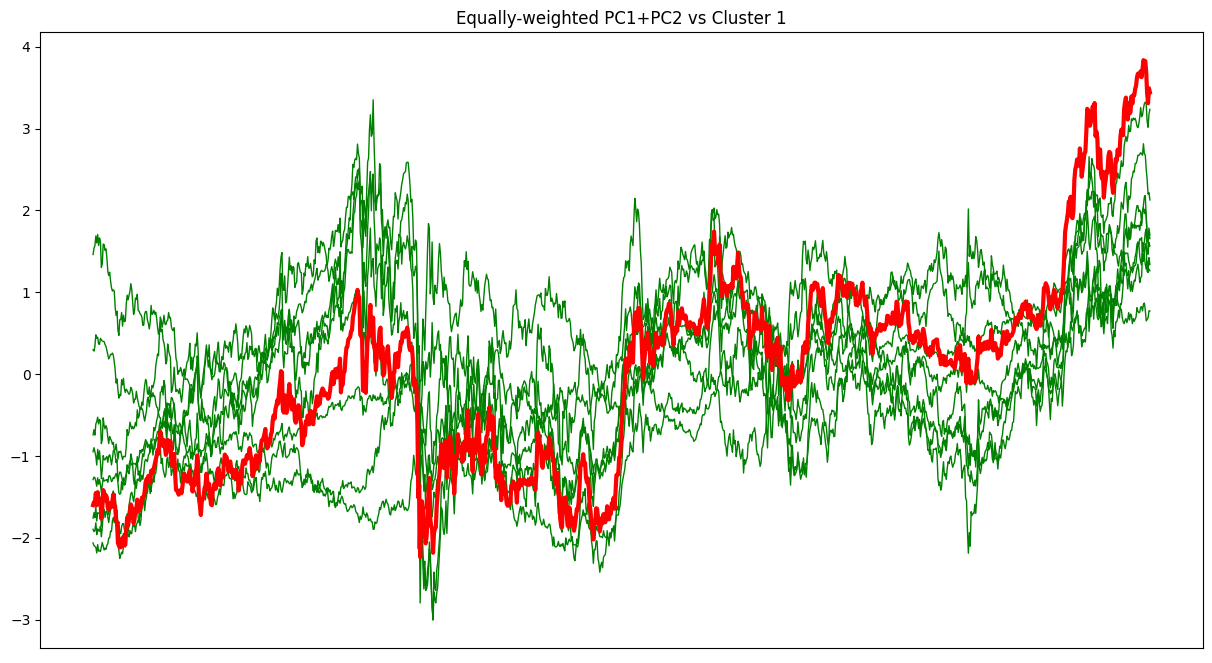

In [7]:
plt.figure(figsize=(15,8))
plt.plot(c1, linewidth = 1, color='green')
plt.plot(c1_pc['Equal_weighted_PC'], linewidth = 3, color='red')
plt.title('Equally-weighted PC1+PC2 vs Cluster 1')
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

The first two PCs for the cluster 1 can explain about 79% of the variance

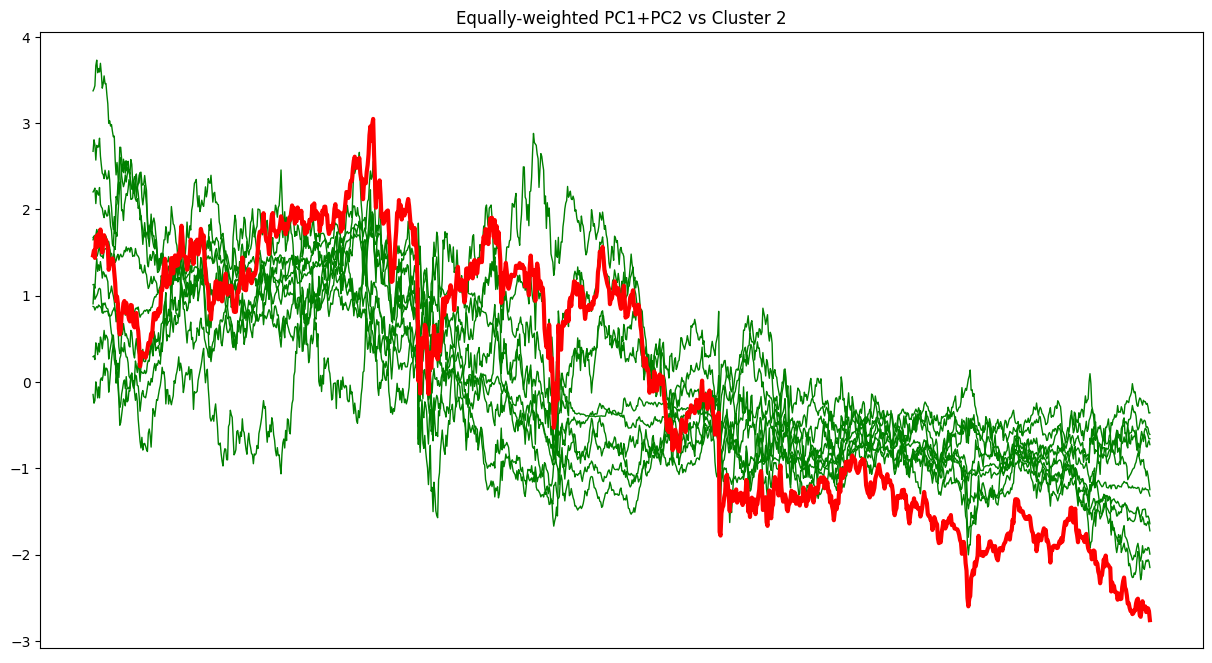

In [8]:
plt.figure(figsize=(15,8))
plt.plot(c2, linewidth = 1, color='green')
plt.plot(c2_pc['Equal_weighted_PC'], linewidth = 3, color='red')
plt.title('Equally-weighted PC1+PC2 vs Cluster 2')
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

The first two PCs for the cluster 2 can explain about 90% of the variance

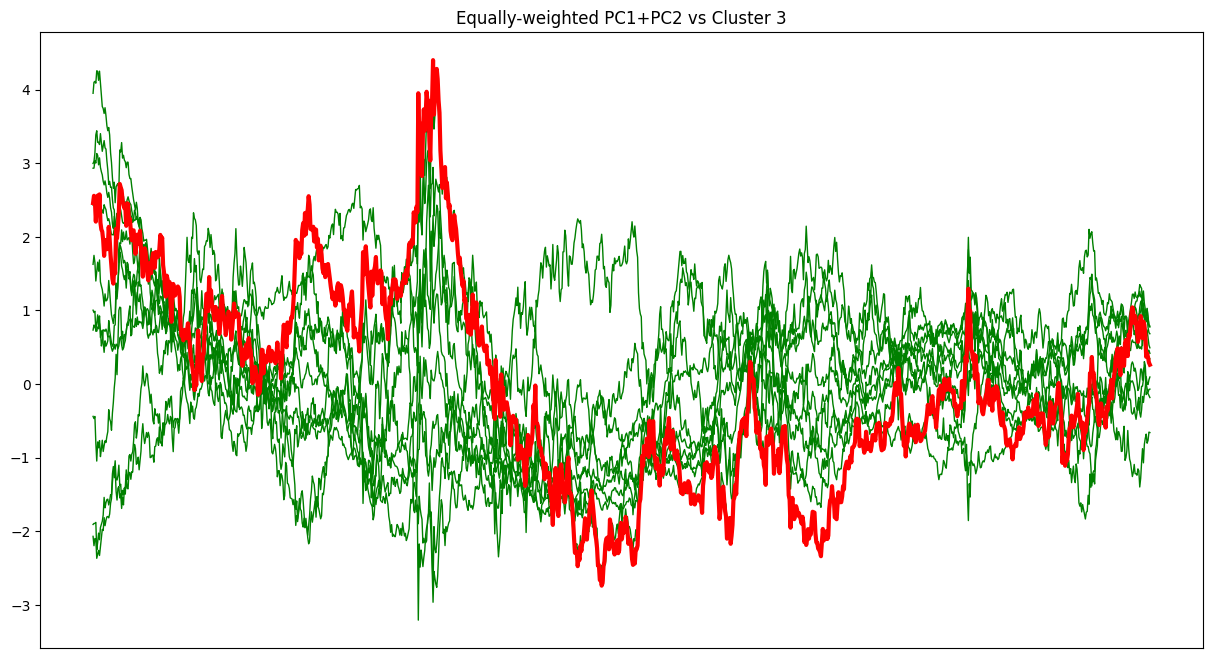

In [9]:
plt.figure(figsize=(15,8))
plt.plot(c3, linewidth = 1, color='green')
plt.plot(c3_pc['Equal_weighted_PC'], linewidth = 3, color='red')
plt.title('Equally-weighted PC1+PC2 vs Cluster 3')
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

The first two PCs for the cluster 3 can explain about 75% of the variance

We then proceed to identify if there could be any index that matches the respective Principle Components movement.  
The whole idea here is if we could identify certain macro measurement such as indexes or any other time series, we could effectively conclude that this specific macro measurement might be of a significant contributor to that specific cluster.

### Cluster 1 vs Growth

Cluster 1 looks to consist mostly of JPY crosses, which can be considered a potential measurement of growth. This is particularly true during the long period of Bank of Japan negative interest rate policy.  
  
This effectively allow JPY to be an effective funder, where Japanese investment firms borrow JPY in negative interest rate (this means they make money from borrowing money), sell theJPY currency into other foreign currencies for investment.  


This implies that a weakness of JPY could be a decent measurement of growth.  
This particular insight points my direction to look for growth index, and in case I found the MSCI Growth index.

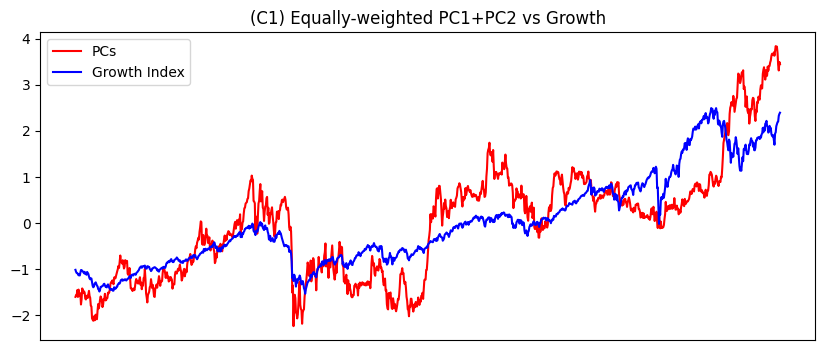

In [10]:
plt.figure(figsize=(10,4))
plt.plot(c1_pc['Equal_weighted_PC'], label='PCs', color='red')
plt.plot(factors_scaled[['Growth']], label='Growth Index', color='blue')
plt.title('(C1) Equally-weighted PC1+PC2 vs Growth')
plt.gca().axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()

In [11]:
pd.concat([c1_pc[['Equal_weighted_PC']], factors_scaled[['Growth']]], axis=1).corr()

,Equal_weighted_PC,Growth
Equal_weighted_PC,1.000000,0.824704
Growth,0.824704,1.000000


Correlation of 0.82 looks relativley high, this looks to be a decent match.

In [12]:
c1_r = c1.pct_change().dropna()
c1_r['return'] = c1_r.sum(axis=1)

c1_pos = c1_r['return'] > 0
factor1_pos = factors_scaled_r['Growth'] > 0
c1_comp = c1_pos == factor1_pos
c1_comp.sum() / len(c1_comp)

0.4864864864864865

Above means that 48.65% of the time the cluster moves in the same direction of the index.  
Meaning when the total return of the cluster is positive, the return of the index is also positive, vice versa.

### Cluster 2 vs Yield Differential

Cluster 2 looks the most "confusing" where it has the most diversed crosses in currency pairs.  
By leveraging my limited domain knowledge, I still find it difficult to isolate any potential factor that could be of the "driver" of the totality of this cluster.  
  
However, by looking at the time series of the Principle Component chart, it looks to have a steady downtrend from end of 2009.
  
This insight points my direction to US 2y-10y yield differential, which is a measurement of yield inversion.  

The US 2x10 yield differentails refers to the spread between 10-year US Treasury yield and 2-year US Treasury yield. During recession or crisis, or leading into one, markets investors tend to pursue safety in the longer tenor investment, thus driving the yield of the 10y Treasury lower. When this process dragged on, an inverted yield curve would occur, where the yield of the 10y Treasury is lower than 2y Treasury.  

A yield curve inversion is interpreted as a risk aversion signal to the market. Consequently, during the period of risk aversion, FX investors/traders tend to stay away from crosses or less popularly traded pairs, in avoidance of additional risk. 

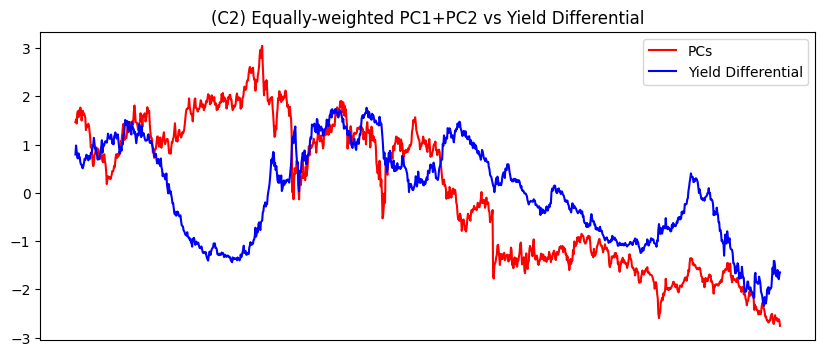

In [13]:
plt.figure(figsize=(10,4))
plt.plot(c2_pc['Equal_weighted_PC'], label='PCs', color='red')
plt.plot(factors_scaled[['2x10 Yield Diff']], label='Yield Differential', color='blue')
plt.title('(C2) Equally-weighted PC1+PC2 vs Yield Differential')
plt.gca().axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()

In [14]:
pd.concat([c2_pc[['Equal_weighted_PC']], factors_scaled[['2x10 Yield Diff']]], axis=1).corr()

,Equal_weighted_PC,2x10 Yield Diff
Equal_weighted_PC,1.000000,0.415141
2x10 Yield Diff,0.415141,1.000000


Correlation of 0.42 does not look that great, most likely due to sudden inversion of yield during 2009

In [15]:
c2_r = c2.pct_change().dropna()
c2_r['return'] = c2_r.sum(axis=1)

c2_pos = c2_r['return'] > 0
factor2_pos = factors_scaled_r['2x10 Yield Diff'] > 0
c2_comp = c2_pos == factor2_pos
c2_comp.sum() / len(c2_comp)

0.5004359197907585

Regardless, the cluster 2 could achieve a hit rate of 50% with the yield differential factor

### Cluster 3 vs Commodities

Cluster 3 looks to be centric around commodities export countries such as US, Canada and New Zealand.  
  
This directly points my direction to look at the commodities index, and in case I used Bloomberg Commodities Index.

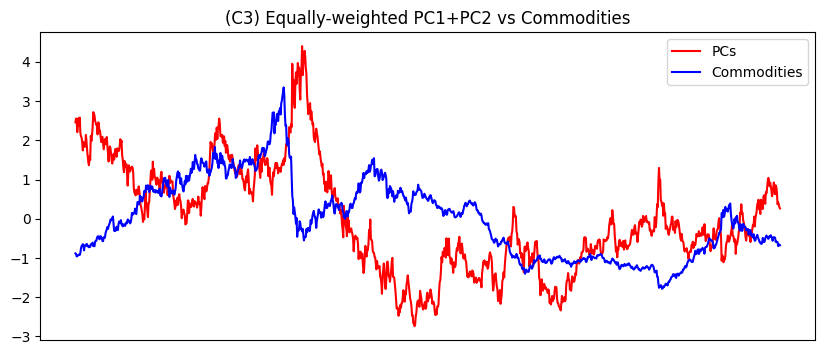

In [16]:
plt.figure(figsize=(10,4))
plt.plot(c3_pc['Equal_weighted_PC'], label='PCs', color='red')
plt.plot(factors_scaled[['Commodities']], label='Commodities', color='blue')
plt.title('(C3) Equally-weighted PC1+PC2 vs Commodities')
plt.gca().axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()

In [17]:
pd.concat([c3_pc[['Equal_weighted_PC']], factors_scaled[['Commodities']]], axis=1).corr()

,Equal_weighted_PC,Commodities
Equal_weighted_PC,1.00000,0.25875
Commodities,0.25875,1.00000


Correlation of 0.26 is not great

In [18]:
c3_r = c3.pct_change().dropna()
c3_r['return'] = c3_r.sum(axis=1)

c3_pos = c3_r['return'] > 0
factor3_pos = factors_scaled_r['Commodities'] > 0
c3_comp = c3_pos == factor3_pos
c3_comp.sum() / len(c3_comp)

0.5387968613775065

Surprisingly, the cluster 3 could achieve a hit rate of more than 50% with the commodities index

### Capture Ratio

In [19]:
c1_positive_r = c1_r[c1_comp][['return']][c1_r[['return']]>0].dropna()
c1_negative_r = c1_r[c1_comp][['return']][c1_r[['return']]<0].dropna()
f1_positive_r = factors_scaled_r[c1_comp][['Growth']][factors_scaled_r[c1_comp][['Growth']]>0].dropna()
f1_negative_r = factors_scaled_r[c1_comp][['Growth']][factors_scaled_r[c1_comp][['Growth']]<0].dropna()

c1_capture = pd.DataFrame({'Positive': [c1_positive_r.mean().values[0], f1_positive_r.mean().values[0]],
                        'Negative': [c1_negative_r.mean().values[0], f1_negative_r.mean().values[0]]})

c1_capture

,Positive,Negative
0,2.422041,-2.313212
1,0.182320,-0.989658


In [20]:
c1_capture['Positive'][1] / c1_capture['Positive'][0], c1_capture['Negative'][1] / c1_capture['Negative'][0]

(0.07527545912808553, 0.4278286629282489)

That means one unit positive return in the cluster points to 0.0753 unit positive return in the Growth factor  
Conversely, 0.4278 unit is expected for one unit of negative return in the Growth factor

In [21]:
c2_positive_r = c2_r[c2_comp][['return']][c2_r[['return']]>0].dropna()
c2_negative_r = c2_r[c2_comp][['return']][c2_r[['return']]<0].dropna()
f2_positive_r = factors_scaled_r[c2_comp][['2x10 Yield Diff']][factors_scaled_r[c2_comp][['2x10 Yield Diff']]>0].dropna()
f2_negative_r = factors_scaled_r[c2_comp][['2x10 Yield Diff']][factors_scaled_r[c2_comp][['2x10 Yield Diff']]<0].dropna()

c2_capture = pd.DataFrame({'Positive': [c2_positive_r.mean().values[0], f2_positive_r.mean().values[0]],
                        'Negative': [c2_negative_r.mean().values[0], f2_negative_r.mean().values[0]]})

c2_capture

,Positive,Negative
0,2.246757,-1.892887
1,0.390914,-0.179251


In [22]:
c2_capture['Positive'][1] / c2_capture['Positive'][0], c2_capture['Negative'][1] / c2_capture['Negative'][0]

(0.17399017764933014, 0.09469722649346651)

That means one unit positive return in the cluster points to 0.1740 unit positive return in the yield differential factor  
Conversely, 0.0947 unit is expected for one unit of negative return in the yield differential factor

In [23]:
c3_positive_r = c3_r[c1_comp][['return']][c3_r[['return']]>0].dropna()
c3_negative_r = c3_r[c1_comp][['return']][c3_r[['return']]<0].dropna()
f3_positive_r = factors_scaled_r[c3_comp][['2x10 Yield Diff']][factors_scaled_r[c3_comp][['2x10 Yield Diff']]>0].dropna()
f3_negative_r = factors_scaled_r[c3_comp][['2x10 Yield Diff']][factors_scaled_r[c3_comp][['2x10 Yield Diff']]<0].dropna()

c3_capture = pd.DataFrame({'Positive': [c3_positive_r.mean().values[0], f3_positive_r.mean().values[0]],
                        'Negative': [c3_negative_r.mean().values[0], f3_negative_r.mean().values[0]]})

c3_capture

,Positive,Negative
0,8.065689,-23.681616
1,0.359877,-0.320584


In [24]:
c3_capture['Positive'][1] / c3_capture['Positive'][0], c3_capture['Negative'][1] / c3_capture['Negative'][0]

(0.04461823706680936, 0.013537268495621929)

That means one unit positive return in the cluster points to 0.0446 unit positive return in the Commodities factor  
Conversely, 0.0135 unit is expected for one unit of negative return in the Commodities factor